# Module C: RAG Architecture & Latency Profiler

**Goal:** Meet the strict 1.5s SLA while maintaining accuracy.

**Persona:** Solutions Architect


## 60-minute workshop flow (recommended)

### Run of show
- **0–10 min**: Environment + NIM preflight, then a fast **smoke test**.
- **10–25 min**: Baseline latency waterfall + interpret where time goes.
- **25–40 min**: **Top_K vs latency vs accuracy** (real eval + plots).
- **40–55 min**: **Hit the 1.5s SLA** challenge (optimize config) + see accuracy tradeoffs.
- **55–60 min**: Caching + robustness quick hits, then takeaways.

### If you’re behind
- Skip Phase 2 (RAGAS) and run only:
  - Smoke test
  - Top_K sweep
  - SLA challenge

### Checkpoints
- **By minute 10**: you can run one query end-to-end and see an **answer + waterfall**.
- **By minute 40**: you have **Top_K vs accuracy** and **Top_K vs latency** figures.
- **By minute 55**: you found a config that **passes SLA** and you can explain the tradeoffs.



In [4]:
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Widgets are optional; notebook works without them.
import ipywidgets as widgets
from IPython.display import display, clear_output

from sentence_transformers import SentenceTransformer, CrossEncoder

from rag_pipeline import (
    RAGConfig,
    Timer,
    VectorIndex,
    build_chunks_from_df,
    chunk_text,
    make_prompt,
    normalize_rows,
    clean_answer,
)
from nim_clients import NIMClient, NIMConfig

print("✅ Module C initialized")


✅ Module C initialized


In [5]:
# --- Environment + kernel sanity checks (fail-fast) ---
import sys
import subprocess

print("=== Python kernel ===")
print("sys.executable:", sys.executable)

print("\n=== Core imports ===")
for name in ["numpy", "pandas", "plotly", "torch", "transformers", "sentence_transformers"]:
    try:
        mod = __import__(name)
        ver = getattr(mod, "__version__", "?")
        print(f"✅ {name} {ver}")
    except Exception as e:
        print(f"❌ {name}: {type(e).__name__}: {e}")

print("\n=== GPU / driver ===")
try:
    import torch

    print("torch.cuda.is_available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("torch.cuda.get_device_name:", torch.cuda.get_device_name(0))
except Exception as e:
    print("torch check failed:", type(e).__name__, str(e)[:200])

try:
    out = subprocess.check_output(["nvidia-smi", "-L"], stderr=subprocess.STDOUT, text=True)
    print(out.strip())
except Exception as e:
    print("nvidia-smi unavailable:", type(e).__name__, str(e)[:200])

print("\nIf you saw missing imports above, run:\n  cd fico && ./scripts/setup_workshop.sh\nThen restart the kernel and select: Python (fico)")



=== Python kernel ===
sys.executable: /home/shadeform/workshop-v1/fico/.venv/bin/python

=== Core imports ===
✅ numpy 2.2.6
✅ pandas 2.3.3
✅ plotly 6.5.0
✅ torch 2.9.1+cu128
✅ transformers 4.57.3
✅ sentence_transformers 5.2.0

=== GPU / driver ===
torch.cuda.is_available: True
torch.cuda.get_device_name: NVIDIA H200
GPU 0: NVIDIA H200 (UUID: GPU-242925e0-6109-3d8c-ea10-753f827ecb29)

If you saw missing imports above, run:
  cd fico && ./scripts/setup_workshop.sh
Then restart the kernel and select: Python (fico)


In [ ]:
os.environ["HF_TRUST_REMOTE_CODE"]="1"

In [6]:
# --- NIM preflight + auto-select mode ---
# This runs before we build models/indexes so you know early whether NIM is available.

from nim_clients import NIMClient, NIMConfig

nim_probe = NIMClient(NIMConfig())

NIM_OK = False
try:
    _embs, _dt = nim_probe.embed(["ping"])
    NIM_OK = True
    print(f"✅ NIM reachable at {nim_probe.cfg.base_url} (embed latency {float(_dt):.3f}s)")
except Exception as e:
    print(f"ℹ️ NIM not reachable at {nim_probe.cfg.base_url}: {type(e).__name__}: {str(e)[:180]}")
    print("To start local NIMs:")
    print("  cd fico && export NGC_API_KEY=... && ./scripts/start_nims.sh")

# If widgets exist later, we’ll set the default value when w_mode is created.
DEFAULT_MODE = "nim" if NIM_OK else "local"
print("Default mode:", DEFAULT_MODE)



✅ NIM reachable at http://localhost:8000 (embed latency 0.409s)
Default mode: nim


## Workshop Setup Notes

### Models
- **Local generation/judge**: `LOCAL_GEN_MODEL` (default: `meta-llama/Llama-3.1-8B-Instruct`)
- **Local embedding**: `LOCAL_EMBED_MODEL` (default: `sentence-transformers/all-MiniLM-L6-v2`)
- **Local reranker**: `LOCAL_RERANK_MODEL` (default: `cross-encoder/ms-marco-MiniLM-L-6-v2`)

### NIM endpoints (localhost)
This lab expects NIMs to be running locally and reachable via HTTP.

You can override endpoints/models using env vars:
- `NIM_API_KEY` (optional)
- `NIM_EMBED_MODEL`, `NIM_RERANK_MODEL`, `NIM_GEN_MODEL`
- `NIM_EMBED_PATH` (default `/v1/embeddings`)
- `NIM_RERANK_PATH` (default `/v1/rerank`)
- `NIM_CHAT_PATH` (default `/v1/chat/completions`)
- `NIM_BASE_URL` (default `http://localhost:8000`)

### What is measured in the SLA waterfall
- The waterfall measures **per-request latency** for query embed/retrieve/rerank/generate.
- **Index building** (chunk embedding for the corpus) is cached and is not part of the SLA.

### If widgets don’t work
Scroll to the bottom for the **NO-WIDGET FALLBACK** cell.


## Phase 1: Real Latency Waterfall (Local vs NIM)

This phase runs a **real** RAG request and measures wall-clock time for:

- Embed query
- Retrieve (vector index)
- Rerank
- Generate

Then it plots a measured waterfall and checks the 1.5s SLA.

We run it in two modes:
- **Local**: embedding + rerank + generation in-process
- **NIM**: embedding + rerank + generation via localhost NIM endpoints


In [7]:
# --- Load corpus from Module B run (single remaining run) ---
RUN_DIR = Path("corpus_runs/llm_richer_n20_20251211_193028")
CSV_PATH = RUN_DIR / "fico_corpus_embedded.csv"

if not CSV_PATH.exists():
    raise FileNotFoundError(f"Missing corpus CSV: {CSV_PATH}")

df_docs = pd.read_csv(CSV_PATH)

# Parse list-like columns stored as JSON strings
for col in ["tags", "allowed_roles", "allowed_tenants", "restricted_tags"]:
    if col in df_docs.columns:
        df_docs[col] = df_docs[col].apply(lambda v: json.loads(v) if isinstance(v, str) and v.strip().startswith("[") else [])

print(f"✅ Loaded {len(df_docs)} docs from {CSV_PATH}")


# --- Build chunk dataset ---
# Use redacted body to avoid leaking sensitive lines during workshops.
chunks = build_chunks_from_df(df_docs)

# Respect chunk settings via widgets; default chunking above is coarse, so we'll rebuild chunks when chunk_size changes.

def build_chunks(chunk_size: int, overlap: int):
    out = []
    for _, row in df_docs.iterrows():
        doc_id = str(row.get("doc_id"))
        title = row.get("title")
        tenant_id = row.get("tenant_id")
        doc_type = row.get("doc_type")
        tags = row.get("tags")
        body = row.get("body_redacted") or row.get("body") or ""
        parts = chunk_text(str(body), chunk_size=chunk_size, overlap=overlap)
        for j, part in enumerate(parts):
            out.append(
                {
                    "doc_id": doc_id,
                    "chunk_id": f"{doc_id}::c{j:03d}",
                    "title": str(title) if title is not None else None,
                    "tenant_id": str(tenant_id) if tenant_id is not None else None,
                    "doc_type": str(doc_type) if doc_type is not None else None,
                    "tags": list(tags) if isinstance(tags, list) else [],
                    "text": part,
                }
            )
    return out


# --- Models ---
# Local models
LOCAL_EMBED_MODEL = os.environ.get("LOCAL_EMBED_MODEL", "sentence-transformers/all-MiniLM-L6-v2")
LOCAL_RERANK_MODEL = os.environ.get("LOCAL_RERANK_MODEL", "cross-encoder/ms-marco-MiniLM-L-6-v2")
# Text-only default (works with AutoModelForCausalLM). Override via env var.
LOCAL_GEN_MODEL = os.environ.get("LOCAL_GEN_MODEL", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")

local_embedder = SentenceTransformer(LOCAL_EMBED_MODEL, device="cuda")
local_reranker = CrossEncoder(LOCAL_RERANK_MODEL, device="cuda")

# NIM client
nim = NIMClient(NIMConfig())


def embed_local(texts: list[str]):
    emb = local_embedder.encode(texts, normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False)
    return emb.astype(np.float32)


def rerank_local(query: str, docs: list[str]):
    pairs = [(query, d) for d in docs]
    scores = local_reranker.predict(pairs)
    order = np.argsort(-np.array(scores))
    return order.tolist(), scores


_LOCAL_GEN = {"tok": None, "model": None}


def ensure_local_generator():
    if _LOCAL_GEN["tok"] is not None and _LOCAL_GEN["model"] is not None:
        return _LOCAL_GEN["tok"], _LOCAL_GEN["model"]

    import torch
    from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

    trust_remote_code = str(os.environ.get("HF_TRUST_REMOTE_CODE", "0")).lower() in {"1", "true", "yes"}

    # Fail fast on known vision configs (e.g. GLM-4V) which cannot be loaded as a text CausalLM.
    try:
        cfg = AutoConfig.from_pretrained(LOCAL_GEN_MODEL, trust_remote_code=trust_remote_code)
    except KeyError as e:
        # Usually indicates your transformers version doesn't recognize a new `model_type`.
        raise ValueError(
            f"Transformers in this environment doesn't recognize model_type={e!s} while loading LOCAL_GEN_MODEL={LOCAL_GEN_MODEL!r}. "
            "Fix: (1) pick a simpler text model like TinyLlama/TinyLlama-1.1B-Chat-v1.0, or (2) upgrade transformers (pip install -U transformers), "
            "or (3) set HF_TRUST_REMOTE_CODE=1 if the model requires custom loading code."
        ) from e
    except Exception as e:
        raise ValueError(
            f"Failed to load config for LOCAL_GEN_MODEL={LOCAL_GEN_MODEL!r}: {type(e).__name__}: {e}"
        ) from e

    if cfg.__class__.__name__.lower().startswith("glm4v") or getattr(cfg, "model_type", "") in {"glm4v", "glm-4v"}:
        raise ValueError(
            "LOCAL_GEN_MODEL appears to be a vision (VLM) model config, which can't be loaded via AutoModelForCausalLM. "
            "Set LOCAL_GEN_MODEL to a text-only causal LM (e.g. TinyLlama/TinyLlama-1.1B-Chat-v1.0) or switch Mode to 'nim'."
        )

    tok = AutoTokenizer.from_pretrained(LOCAL_GEN_MODEL, use_fast=True, trust_remote_code=trust_remote_code)
    tok.padding_side = "left"
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16

    model = AutoModelForCausalLM.from_pretrained(
        LOCAL_GEN_MODEL,
        device_map="auto",
        torch_dtype=dtype,
        trust_remote_code=trust_remote_code,
    )
    model.eval()

    _LOCAL_GEN["tok"] = tok
    _LOCAL_GEN["model"] = model
    return tok, model


def gen_local(prompt: str, max_new_tokens: int, temperature: float):
    import torch

    tok, model = ensure_local_generator()

    inputs = tok([prompt], return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=True,
            temperature=float(temperature),
            top_p=0.95,
            max_new_tokens=int(max_new_tokens),
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
        )

    gen_ids = out[0, inputs["input_ids"].shape[1] :]
    return tok.decode(gen_ids, skip_special_tokens=True).strip()


def build_index_for_mode(mode: str, chunk_rows: list[dict], use_faiss: bool = True):
    texts = [r["text"] for r in chunk_rows]

    if mode == "local":
        E = embed_local(texts)
        E_norm = normalize_rows(E)
        return VectorIndex(E_norm, use_faiss=use_faiss), E_norm

    if mode == "nim":
        # Batch to avoid request-size limits
        embs, _ = nim.embed_many(texts, batch_size=64)
        E = np.array(embs, dtype=np.float32)
        E_norm = normalize_rows(E)
        return VectorIndex(E_norm, use_faiss=use_faiss), E_norm

    raise ValueError(f"unknown mode: {mode}")


def run_rag(query: str, *, mode: str, chunk_rows: list[dict], index: VectorIndex, cfg: RAGConfig):
    timer = Timer()

    # Embed query
    if mode == "local":
        q_emb = timer.time("embed", lambda: embed_local([query])[0])
        net_t = 0.0
    else:
        embs, net_t = timer.time("network+embed", lambda: nim.embed([query]))
        q_emb = np.array(embs[0], dtype=np.float32)

    q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-12)

    # Retrieve
    idxs, sims = timer.time("retrieve", lambda: index.search(q_norm, cfg.top_k))
    idxs = [int(i) for i in idxs]

    candidates = [chunk_rows[i] for i in idxs]

    # Rerank
    if cfg.rerank_top_k > 0:
        docs = [c["text"] for c in candidates]
        if mode == "local":
            order, _ = timer.time("rerank", lambda: rerank_local(query, docs))
        else:
            order, _ = timer.time("network+rerank", lambda: nim.rerank(query, docs, top_n=min(cfg.rerank_top_k, len(docs))))

        # NIM rerank returns indices into docs; local returns order
        if isinstance(order, list) and order and isinstance(order[0], int):
            reranked = [candidates[i] for i in order[: cfg.rerank_top_k]]
        else:
            reranked = candidates[: cfg.rerank_top_k]
    else:
        reranked = candidates

    # Context packing
    context = []
    used = 0
    for r in reranked:
        t = r["text"]
        if used + len(t) > cfg.max_context_chars:
            break
        context.append(r)
        used += len(t)

    from rag_pipeline import Chunk

    context_chunks = [
        Chunk(
            doc_id=str(r.get("doc_id")),
            chunk_id=str(r.get("chunk_id")),
            text=str(r.get("text")),
            title=r.get("title"),
            tenant_id=r.get("tenant_id"),
            doc_type=r.get("doc_type"),
            tags=r.get("tags") if isinstance(r.get("tags"), list) else [],
        )
        for r in context
    ]

    prompt = make_prompt(query, context_chunks)

    # Generate
    if mode == "local":
        answer = timer.time("generate", lambda: gen_local(prompt, cfg.max_new_tokens, cfg.temperature))
    else:
        answer, _ = timer.time("network+generate", lambda: nim.chat(prompt, max_tokens=cfg.max_new_tokens, temperature=cfg.temperature))

    # Timings
    timings = dict(timer.timings)
    if net_t and "network+embed" not in timings:
        timings["network+embed"] = float(net_t)

    return answer, context, timings


def plot_measured_waterfall(timings_s: dict, title: str):
    # Normalize keys into ordered components
    keys = [
        "network+embed",
        "embed",
        "retrieve",
        "network+rerank",
        "rerank",
        "network+generate",
        "generate",
    ]
    labels = {
        "network+embed": "NIM:Embed (HTTP)",
        "embed": "Embed",
        "retrieve": "Retrieve",
        "network+rerank": "NIM:Rerank (HTTP)",
        "rerank": "Rerank",
        "network+generate": "NIM:Gen (HTTP)",
        "generate": "Generate",
    }

    parts = [(k, float(timings_s.get(k, 0.0))) for k in keys if float(timings_s.get(k, 0.0)) > 0]
    total = sum(v for _, v in parts)

    fig = go.Figure(
        go.Waterfall(
            name="Latency",
            orientation="v",
            measure=["relative"] * len(parts) + ["total"],
            x=[labels[k] for k, _ in parts] + ["TOTAL"],
            textposition="outside",
            text=[f"{v:.3f}s" for _, v in parts] + [f"{total:.3f}s"],
            y=[v for _, v in parts] + [0],
            connector={"line": {"color": "rgb(63, 63, 63)"}},
        )
    )

    fig.add_hline(
        y=1.5,
        line_dash="dot",
        annotation_text="SLA Limit (1.5s)",
        line_color="red" if total > 1.5 else "green",
    )

    fig.update_layout(title=title, showlegend=False, yaxis=dict(title="Time (seconds)", range=[0, max(2.5, total * 1.2)]))
    fig.show()

    print(f"⏱️ TOTAL LATENCY: {total:.3f}s")
    if total > 1.5:
        print("❌ FAILED SLA. Optimize configuration!")
    else:
        print("✅ PASSED SLA.")


# -- CONTROLS (optional) --
style = {"description_width": "initial"}

w_chunk = widgets.IntSlider(value=900, min=200, max=2000, description="Chunk Size (chars):", style=style)
w_overlap = widgets.IntSlider(value=150, min=0, max=500, description="Overlap (chars):", style=style)
w_k = widgets.IntSlider(value=10, min=1, max=50, description="Top_K Chunks:", style=style)
w_rerank_k = widgets.IntSlider(value=5, min=0, max=20, description="Rerank Top_K:", style=style)

w_query = widgets.Text(value="Kubernetes incident runbook", description="Query:")

# Auto-default to NIM if reachable, otherwise local.
_default_mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"
w_mode = widgets.Dropdown(options=["local", "nim"], value=_default_mode, description="Mode:")
btn_run = widgets.Button(description="Run RAG + plot latency")
btn_compare = widgets.Button(description="Compare Local vs NIM (SLA)")

out = widgets.Output()

# Cache indexes per mode + chunk settings so repeated runs are fast
_INDEX_CACHE = {}


def get_index(mode: str, chunk_size: int, overlap: int):
    key = (mode, int(chunk_size), int(overlap))
    if key in _INDEX_CACHE:
        return _INDEX_CACHE[key]

    rows = build_chunks(int(chunk_size), int(overlap))
    index, _ = build_index_for_mode(mode, rows, use_faiss=True)
    _INDEX_CACHE[key] = (rows, index)
    return _INDEX_CACHE[key]


def on_run_click(b):
    with out:
        clear_output()
        rows, index = get_index(w_mode.value, w_chunk.value, w_overlap.value)
        cfg = RAGConfig(mode=w_mode.value, top_k=int(w_k.value), rerank_top_k=int(w_rerank_k.value))
        answer, context, timings = run_rag(w_query.value, mode=w_mode.value, chunk_rows=rows, index=index, cfg=cfg)
        plot_measured_waterfall(timings, title=f"RAG Latency ({w_mode.value})")

        cleaned = clean_answer(answer or "")
        print("\n--- Answer ---")
        if not cleaned:
            print("(empty)")
        elif len(cleaned) > 4000:
            print(cleaned[:4000] + "\n... [truncated] ...")
        else:
            print(cleaned)


def on_compare_click(b):
    with out:
        clear_output()

        rows_l, idx_l = get_index("local", w_chunk.value, w_overlap.value)
        rows_n, idx_n = get_index("nim", w_chunk.value, w_overlap.value)

        cfg_l = RAGConfig(mode="local", top_k=int(w_k.value), rerank_top_k=int(w_rerank_k.value))
        cfg_n = RAGConfig(mode="nim", top_k=int(w_k.value), rerank_top_k=int(w_rerank_k.value))

        q = w_query.value

        ans_l, ctx_l, t_l = run_rag(q, mode="local", chunk_rows=rows_l, index=idx_l, cfg=cfg_l)
        ans_n, ctx_n, t_n = run_rag(q, mode="nim", chunk_rows=rows_n, index=idx_n, cfg=cfg_n)

        print("=== LOCAL ===")
        plot_measured_waterfall(t_l, title="RAG Latency (local)")
        print("\n=== NIM ===")
        plot_measured_waterfall(t_n, title="RAG Latency (nim)")

        total_l = float(sum(t_l.values()))
        total_n = float(sum(t_n.values()))
        print("\n=== Comparison ===")
        print(f"Local total: {total_l:.3f}s")
        print(f"NIM total:   {total_n:.3f}s")
        print(f"Delta (NIM-Local): {(total_n-total_l):+.3f}s")


btn_run.on_click(on_run_click)
btn_compare.on_click(on_compare_click)

display(widgets.VBox([
    widgets.HBox([w_mode, btn_run, btn_compare]),
    w_query,
    widgets.HBox([w_chunk, w_overlap]),
    widgets.HBox([w_k, w_rerank_k]),
    out,
]))


✅ Loaded 69 docs from corpus_runs/llm_richer_n20_20251211_193028/fico_corpus_embedded.csv


## Checkpoint: 5-minute smoke test

Run this once after **Phase 1 setup** (the big cell that defines functions and widgets). It should:
- Build/reuse an index
- Run one RAG query
- Show an answer + latency waterfall



In [ ]:
# Fast smoke test (non-widget)

SMOKE_QUERY = "Kubernetes incident runbook"
SMOKE_TOP_K = 5
SMOKE_RERANK_K = 3
SMOKE_MAX_NEW_TOKENS = 80

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"
print("Smoke test mode:", mode)

missing = [name for name in ["get_index", "run_rag", "plot_measured_waterfall"] if name not in globals()]
if missing:
    raise RuntimeError(
        "Missing functions: " + ", ".join(missing) + "\nRun the Phase 1 setup cell above first (the big cell that defines functions and widgets)."
    )

rows, index = get_index(mode, chunk_size=900, overlap=150)
cfg = RAGConfig(mode=mode, top_k=SMOKE_TOP_K, rerank_top_k=SMOKE_RERANK_K, max_new_tokens=SMOKE_MAX_NEW_TOKENS)
ans, ctx, timings = run_rag(SMOKE_QUERY, mode=mode, chunk_rows=rows, index=index, cfg=cfg)

plot_measured_waterfall(timings, title=f"Smoke test latency ({mode})")

print("\n--- Answer ---")
print(clean_answer(ans)[:1200])
print("\n(Context chunks used:", len(ctx), ")")



## Presets: Fast vs Balanced vs Accurate

These presets are meant to make the tradeoffs visible:
- **Fast**: usually passes SLA, lower answer quality
- **Balanced**: a reasonable default
- **Accurate**: higher recall/precision, typically slower

We’ll compare them with a **stacked latency breakdown** figure.



,preset,total_s,embed_s,retrieve_s,rerank_s,generate_s,answer_preview
0,fast,0.621750,0.019645,0.000159,0.000000,0.601946,Kubernetes incident runbooks cover a range of ...
1,balanced,0.989218,0.021032,0.000166,0.056843,0.911177,Kubernetes incident runbooks cover various sce...
2,accurate,1.722763,0.019867,0.000164,0.070378,1.632354,"For Kubernetes incident runbooks, key areas to..."


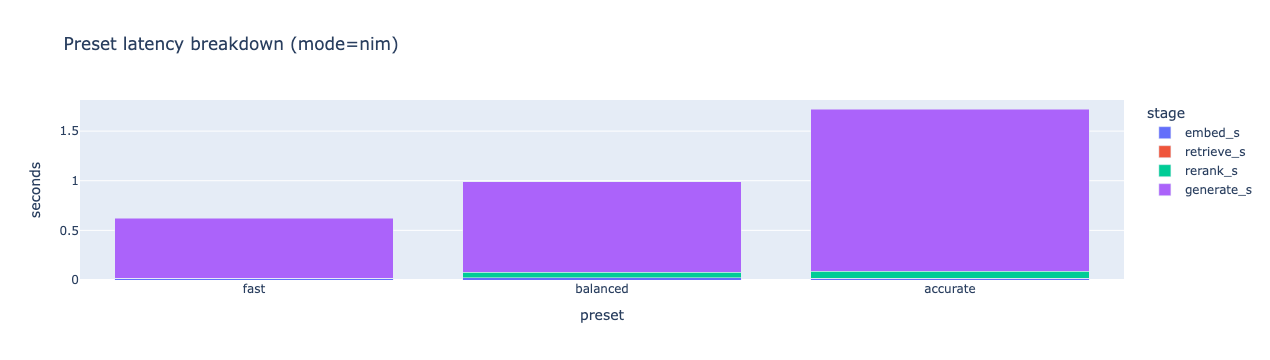

In [8]:
# Preset comparison (non-widget): stacked latency breakdown

PRESETS = {
    "fast": {"chunk_size": 900, "overlap": 150, "top_k": 6, "rerank_top_k": 0, "max_new_tokens": 80, "temperature": 0.2},
    "balanced": {"chunk_size": 900, "overlap": 150, "top_k": 10, "rerank_top_k": 5, "max_new_tokens": 180, "temperature": 0.2},
    "accurate": {"chunk_size": 900, "overlap": 150, "top_k": 20, "rerank_top_k": 10, "max_new_tokens": 220, "temperature": 0.2},
}

PRESET_QUERY = "Kubernetes incident runbook"

missing = [name for name in ["get_index", "run_rag"] if name not in globals()]
if missing:
    raise RuntimeError("Missing functions: " + ", ".join(missing) + "\nRun the Phase 1 setup cell above first.")

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"

rows, index = get_index(mode, chunk_size=900, overlap=150)

records = []
for name, p in PRESETS.items():
    cfg = RAGConfig(
        mode=mode,
        top_k=int(p["top_k"]),
        rerank_top_k=int(p["rerank_top_k"]),
        max_new_tokens=int(p["max_new_tokens"]),
        temperature=float(p["temperature"]),
    )
    ans, ctx, timings = run_rag(PRESET_QUERY, mode=mode, chunk_rows=rows, index=index, cfg=cfg)

    # Normalize stage names for plotting
    stage_map = {
        "network+embed": "embed",
        "embed": "embed",
        "retrieve": "retrieve",
        "network+rerank": "rerank",
        "rerank": "rerank",
        "network+generate": "generate",
        "generate": "generate",
    }
    agg = {}
    for k, v in timings.items():
        kk = stage_map.get(k)
        if kk:
            agg[kk] = agg.get(kk, 0.0) + float(v)

    total = float(sum(timings.values()))
    records.append(
        {
            "preset": name,
            "total_s": total,
            "embed_s": agg.get("embed", 0.0),
            "retrieve_s": agg.get("retrieve", 0.0),
            "rerank_s": agg.get("rerank", 0.0),
            "generate_s": agg.get("generate", 0.0),
            "answer_preview": clean_answer(ans)[:180],
        }
    )

df_p = pd.DataFrame(records).sort_values("total_s")
display(df_p[["preset", "total_s", "embed_s", "retrieve_s", "rerank_s", "generate_s", "answer_preview"]])

fig = px.bar(
    df_p,
    x="preset",
    y=["embed_s", "retrieve_s", "rerank_s", "generate_s"],
    title=f"Preset latency breakdown (mode={mode})",
    labels={"value": "seconds", "variable": "stage"},
)
fig.update_layout(barmode="stack")
fig.show()



## Interlude: RAG is just “context shopping” (and chunking is the aisle layout)

RAG isn’t magic memory. It’s **prompt enrichment**:

1) embed the query
2) cosine-similarity search over chunk embeddings
3) paste the top‑K chunks into the prompt
4) let the LLM answer using that context

If the answer isn’t in the retrieved context, the LLM can’t “remember” it.

Small joke to keep us honest: if you hide the answer *between couch cushions* (a chunk boundary), retrieval can’t find it. The LLM will then do what all of us do under pressure: confidently improvise.



In [ ]:
# Chunking failure playground: the answer can literally fall between chunks.
# (Uses the same cosine + VectorIndex path as the real pipeline.)

import textwrap


def _build_synth_doc(*, key_at: int = 790):
    key = "RECOVERY_KEY=BANANA-42-ALPHA-777"

    # Intentionally include lots of "recovery"-ish language as distractors.
    filler = (
        "Incident runbook note: recovery steps, rollback guidance, postmortem reminders, "
        "and lots of words about recovery that are not actually the key. "
    )

    # Make a prefix of exactly key_at characters so we can force a boundary split for certain chunk sizes.
    prefix = (filler * (key_at // len(filler) + 3))[:key_at]

    suffix = (
        "\n\nMore notes: rotate credentials quarterly. Keep secrets out of Slack. "
        "If you see the word banana in an incident, someone is probably having a bad day."
    )

    doc = prefix + key + suffix
    return doc, key


SYNTH_DOC, SYNTH_KEY = _build_synth_doc(key_at=790)


def _chunk_spans(text: str, chunk_size: int, overlap: int):
    """Return [(chunk_id, start, end, chunk_text)]."""
    chunk_size = max(50, int(chunk_size))
    overlap = max(0, min(int(overlap), chunk_size - 1))

    spans = []
    start = 0
    n = len(text)
    j = 0
    while start < n:
        end = min(n, start + chunk_size)
        spans.append((j, start, end, text[start:end]))
        if end == n:
            break
        start = max(0, end - overlap)
        j += 1
    return spans


def _plot_chunk_strip(spans, *, key: str):
    rows = []
    for j, s, e, t in spans:
        rows.append(
            {
                "chunk": f"c{j:02d}",
                "start": int(s),
                "end": int(e),
                "len": int(e - s),
                "has_key": bool(key in t),
                "preview": (t.replace("\n", " ")[:120] + ("…" if len(t) > 120 else "")),
            }
        )

    df = pd.DataFrame(rows)

    fig = go.Figure()
    for r in rows:
        fig.add_trace(
            go.Bar(
                x=[r["len"]],
                y=["doc"],
                base=[r["start"]],
                orientation="h",
                marker_color=("#16a34a" if r["has_key"] else "#94a3b8"),
                hovertemplate=(
                    "<b>%{customdata[0]}</b><br>chars: %{base}–%{customdata[1]}<br>len=%{x}<br>has_key=%{customdata[2]}<br><br>%{customdata[3]}<extra></extra>"
                ),
                customdata=[[r["chunk"], r["end"], r["has_key"], r["preview"]]],
                showlegend=False,
            )
        )

    fig.update_layout(
        title="Chunk boundary strip (green = contains full key)",
        xaxis_title="character offset",
        yaxis=dict(visible=False),
        barmode="stack",
        height=220,
    )
    return df, fig


def _plot_similarities(df_chunks: pd.DataFrame, retrieved_ids: set[str]):
    dfp = df_chunks.copy()
    dfp["retrieved"] = dfp["chunk"].isin(retrieved_ids)

    fig = px.bar(
        dfp,
        x="chunk",
        y="cosine",
        color="retrieved",
        title="Cosine similarity per chunk (highlighting Top‑K retrieved)",
        hover_data=["has_key"],
    )
    fig.update_layout(xaxis_title="chunk", yaxis_title="cosine similarity")
    return fig


def _pack_context_text(texts: list[str], max_chars: int) -> list[str]:
    out = []
    used = 0
    for t in texts:
        if used + len(t) > int(max_chars):
            break
        out.append(t)
        used += len(t)
    return out


# --- Controls ---
style = {"description_width": "initial"}

w_demo_query = widgets.Text(
    value="What is the RECOVERY_KEY?", description="Query:", layout=widgets.Layout(width="900px"), style=style
)

w_demo_chunk = widgets.IntSlider(value=400, min=120, max=1400, step=20, description="Chunk size (chars)", style=style)
w_demo_overlap = widgets.IntSlider(value=0, min=0, max=400, step=20, description="Overlap (chars)", style=style)
w_demo_topk = widgets.IntSlider(value=3, min=1, max=12, step=1, description="Top‑K", style=style)
w_demo_ctx = widgets.IntSlider(value=900, min=200, max=4000, step=100, description="Max context chars", style=style)

out_demo = widgets.Output()


def _render_demo(*_):
    with out_demo:
        clear_output(wait=True)

        # Chunk the synthetic doc
        spans = _chunk_spans(SYNTH_DOC, chunk_size=int(w_demo_chunk.value), overlap=int(w_demo_overlap.value))
        df_strip, fig_strip = _plot_chunk_strip(spans, key=SYNTH_KEY)

        # Build embeddings + VectorIndex over chunks (same math as the real pipeline)
        chunk_texts = [t for _, _, _, t in spans]
        E = embed_local(chunk_texts)
        E_norm = normalize_rows(E)
        idx = VectorIndex(E_norm, use_faiss=True)

        q = str(w_demo_query.value)
        q_emb = embed_local([q])[0]
        q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-12)

        topk = int(w_demo_topk.value)
        I, sims = idx.search(q_norm, k=topk)

        # Similarities for all chunks (for plotting)
        all_sims = (E_norm @ q_norm.reshape(-1, 1)).reshape(-1)
        df_chunks = df_strip[["chunk", "has_key"]].copy()
        df_chunks["cosine"] = all_sims.astype(float)

        retrieved = [int(i) for i in I]
        retrieved_ids = {f"c{i:02d}" for i in retrieved}

        # Pack context the same way run_rag does (truncate by max_context_chars)
        retrieved_texts = [chunk_texts[i] for i in retrieved]
        packed = _pack_context_text(retrieved_texts, max_chars=int(w_demo_ctx.value))

        has_key_anywhere = any(SYNTH_KEY in t for t in packed)

        print("=== Retrieval result ===")
        print(f"chunk_size={int(w_demo_chunk.value)} overlap={int(w_demo_overlap.value)} top_k={topk} max_context_chars={int(w_demo_ctx.value)}")
        print("Key present in packed context:", has_key_anywhere)
        if not has_key_anywhere:
            print("\nIf the key isn’t in context, the LLM can’t cite it. It will either say ‘I don’t know’ or confidently hallucinate.")

        fig_strip.show()
        _plot_similarities(df_chunks, retrieved_ids=retrieved_ids).show()

        print("\n=== Packed context preview (what the model actually sees) ===")
        for i, t in enumerate(packed, start=1):
            snippet = t.replace("\n", " ")
            print(f"\n[chunk {i}/{len(packed)} | {len(t)} chars]")
            print(textwrap.shorten(snippet, width=450, placeholder=" …"))

        # Quick "extraction" check (acts like a sanity oracle)
        extracted = SYNTH_KEY if has_key_anywhere else None
        print("\n=== Quick extraction check ===")
        print("extracted:", extracted)


for w in [w_demo_query, w_demo_chunk, w_demo_overlap, w_demo_topk, w_demo_ctx]:
    w.observe(_render_demo, names="value")

print("Tip: start with chunk_size=400 overlap=0 (usually broken), then try chunk_size=900 or overlap=200 (usually fixed).")
display(widgets.VBox([w_demo_query, widgets.HBox([w_demo_chunk, w_demo_overlap]), widgets.HBox([w_demo_topk, w_demo_ctx]), out_demo]))

_render_demo()



In [ ]:
# Prompt builder: show the *exact* prompt that would be sent to the generator.
# This uses the same context-packing rule as run_rag (max_context_chars).

from rag_pipeline import Chunk


out_prompt = widgets.Output()

w_p_show = widgets.IntSlider(value=2400, min=400, max=12000, step=200, description="Show first N chars", style=style)


def _render_prompt(*_):
    with out_prompt:
        clear_output(wait=True)

        spans = _chunk_spans(SYNTH_DOC, chunk_size=int(w_demo_chunk.value), overlap=int(w_demo_overlap.value))
        chunk_texts = [t for _, _, _, t in spans]

        # Build embeddings + retrieve (same as the demo above)
        E = embed_local(chunk_texts)
        E_norm = normalize_rows(E)
        idx = VectorIndex(E_norm, use_faiss=True)

        q = str(w_demo_query.value)
        q_emb = embed_local([q])[0]
        q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-12)

        I, _ = idx.search(q_norm, k=int(w_demo_topk.value))
        retrieved_texts = [chunk_texts[int(i)] for i in I]

        packed = _pack_context_text(retrieved_texts, max_chars=int(w_demo_ctx.value))

        ctx_chunks = [Chunk(doc_id="synth", chunk_id=f"synth::c{i:03d}", text=t, title="SyntheticDoc") for i, t in enumerate(packed)]
        prompt = make_prompt(q, ctx_chunks)

        print("=== Prompt stats ===")
        print("prompt_chars:", len(prompt))
        print("context_chunks_used:", len(packed))
        print("max_context_chars setting:", int(w_demo_ctx.value))

        show_n = int(w_p_show.value)
        print("\n=== Prompt preview ===")
        if len(prompt) <= show_n:
            print(prompt)
        else:
            print(prompt[:show_n] + "\n... [truncated for display] ...")


for w in [w_demo_query, w_demo_chunk, w_demo_overlap, w_demo_topk, w_demo_ctx, w_p_show]:
    w.observe(_render_prompt, names="value")

display(widgets.VBox([w_p_show, out_prompt]))

_render_prompt()



## Real accuracy evaluation: Gold QA set + local judge

This section creates a small **gold evaluation set** from the corpus and uses a **local LLM judge** to score correctness.

- The gold set is cached to disk so you don’t regenerate it every run.
- Scores are **0/1/2** (incorrect/partial/correct).

This is the backbone for the **Top_K vs accuracy** and **SLA vs accuracy** exercises.



In [12]:
# Gold set + local judge helpers

import re
from dataclasses import dataclass

CACHE_DIR = Path(".module_c_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
GOLD_PATH = CACHE_DIR / "gold_eval.jsonl"


def _extract_json_object(text: str) -> dict:
    """Best-effort JSON extraction from a model response."""
    s = (text or "").strip()
    if not s:
        raise ValueError("empty model output")

    # Try direct parse first
    try:
        return json.loads(s)
    except Exception:
        pass

    # Extract first {...} block
    m = re.search(r"\{[\s\S]*\}", s)
    if not m:
        raise ValueError("no JSON object found")
    return json.loads(m.group(0))


def _ensure_local_llm():
    """Return (tokenizer, model) using ensure_local_generator if present."""
    if "ensure_local_generator" in globals():
        return ensure_local_generator()

    # Fallback: define a minimal loader using LOCAL_GEN_MODEL
    import torch
    from transformers import AutoModelForCausalLM, AutoTokenizer

    model_id = os.environ.get("LOCAL_GEN_MODEL", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    tok.padding_side = "left"
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=dtype)
    model.eval()
    return tok, model


def llm_generate_deterministic(prompt: str, *, max_new_tokens: int = 220) -> str:
    """Deterministic generation (good for eval/judging)."""
    import torch

    tok, model = _ensure_local_llm()

    inputs = tok([prompt], return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=False,
            temperature=0.0,
            max_new_tokens=int(max_new_tokens),
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
        )

    gen_ids = out[0, inputs["input_ids"].shape[1] :]
    return tok.decode(gen_ids, skip_special_tokens=True).strip()


def build_gold_eval(*, n: int = 6, seed: int = 42, force: bool = False):
    """Build (or load) a small gold set from the corpus: question + reference answer."""
    if GOLD_PATH.exists() and not force:
        rows = [json.loads(line) for line in GOLD_PATH.read_text(encoding="utf-8").splitlines() if line.strip()]
        return rows

    if "df_docs" not in globals():
        raise RuntimeError("df_docs is not defined. Run the Phase 1 setup cell that loads the corpus first.")

    sample = df_docs.sample(n=min(int(n), len(df_docs)), random_state=int(seed))
    out = []

    for _, r in sample.iterrows():
        doc_id = str(r.get("doc_id"))
        ctx = str(r.get("body_redacted") or r.get("body") or "")
        ctx = ctx[:1800]

        prompt = (
            "You are creating a grounded evaluation example for a retrieval-augmented QA system.\n"
            "Return ONLY valid JSON with keys: question, reference_answer, expected_keywords.\n"
            "Rules:\n"
            "- The question MUST be answerable ONLY from the context.\n"
            "- The reference_answer MUST be a short factual answer grounded in the context.\n"
            "- expected_keywords is a list of 3-6 short strings that should appear in a correct answer.\n\n"
            f"CONTEXT:\n{ctx}\n\nJSON:" 
        )

        raw = llm_generate_deterministic(prompt, max_new_tokens=240)
        try:
            j = _extract_json_object(raw)
            q = str(j.get("question") or "").strip()
            a = str(j.get("reference_answer") or "").strip()
            kws = j.get("expected_keywords")
            if not isinstance(kws, list):
                kws = []
            kws = [str(x).strip() for x in kws if str(x).strip()]

            # Minimal sanity
            if len(q) < 8 or len(a) < 8:
                raise ValueError("question/answer too short")

        except Exception:
            # Fallback: still real (derived from corpus), avoids workshop hard-fail.
            q = f"What is a key point from document {doc_id}?"
            a = (ctx.splitlines()[0] if ctx else "I don't know").strip()[:240]
            kws = []

        out.append({"doc_id": doc_id, "question": q, "reference_answer": a, "expected_keywords": kws})

    # Persist
    with open(GOLD_PATH, "w", encoding="utf-8") as f:
        for row in out:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")

    return out


def judge_answer(question: str, reference_answer: str, candidate_answer: str):
    """Return {score:0|1|2, rationale:str} using a local LLM judge."""
    prompt = (
        "You are grading a system answer against a reference answer.\n"
        "Score rubric:\n"
        "- 2 = correct (matches reference in meaning; may be phrased differently)\n"
        "- 1 = partially correct (some correct info but missing/incorrect key parts)\n"
        "- 0 = incorrect or not supported\n\n"
        "Return ONLY valid JSON with keys: score, rationale.\n"
        "rationale should be one short sentence.\n\n"
        f"QUESTION:\n{question}\n\nREFERENCE_ANSWER:\n{reference_answer}\n\nCANDIDATE_ANSWER:\n{candidate_answer}\n\nJSON:"
    )

    raw = llm_generate_deterministic(prompt, max_new_tokens=180)
    try:
        j = _extract_json_object(raw)
        score = int(j.get("score"))
        score = 0 if score < 0 else 2 if score > 2 else score
        rationale = str(j.get("rationale") or "").strip()
        return {"score": score, "rationale": rationale}
    except Exception:
        # Non-mocked fallback: simple keyword overlap against reference.
        ref = (reference_answer or "").lower()
        cand = (candidate_answer or "").lower()
        hits = sum(1 for w in set(ref.split()) if len(w) > 4 and w in cand)
        score = 2 if hits >= 4 else 1 if hits >= 2 else 0
        return {"score": score, "rationale": "fallback keyword-overlap judge"}



In [ ]:
# Build/load the gold evaluation set

GOLD_N = int(os.environ.get("GOLD_N", "6"))
GOLD_SEED = int(os.environ.get("GOLD_SEED", "42"))

print(f"Loading gold set from {GOLD_PATH} (n={GOLD_N}, seed={GOLD_SEED})")

gold_eval = build_gold_eval(n=GOLD_N, seed=GOLD_SEED, force=False)

df_gold = pd.DataFrame(gold_eval)
display(df_gold[["doc_id", "question", "reference_answer"]])

# Pretty summary figure
fig = px.histogram(
    df_gold,
    x=df_gold["reference_answer"].astype(str).str.len(),
    nbins=12,
    title="Gold set: reference answer length distribution (chars)",
    labels={"x": "reference_answer length (chars)", "y": "count"},
)
fig.show()



In [ ]:
# Quick sanity check: judge scores a real RAG run (not mocked)

if not gold_eval:
    raise RuntimeError("gold_eval is empty")

ex = gold_eval[0]
mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"

missing = [name for name in ["get_index", "run_rag"] if name not in globals()]
if missing:
    raise RuntimeError("Missing functions: " + ", ".join(missing) + "\nRun the Phase 1 setup cell above first.")

rows, index = get_index(mode, chunk_size=900, overlap=150)
cfg = RAGConfig(mode=mode, top_k=10, rerank_top_k=5, max_new_tokens=160, temperature=0.2)

ans, ctx, timings = run_rag(ex["question"], mode=mode, chunk_rows=rows, index=index, cfg=cfg)
ans_clean = clean_answer(ans)

retrieval_hit = any(str(c.get("doc_id")) == str(ex["doc_id"]) for c in ctx)
judge = judge_answer(ex["question"], ex["reference_answer"], ans_clean)

print("Question:", ex["question"])
print("Reference:", ex["reference_answer"])
print("\nCandidate:", ans_clean[:600])
print("\nRetrieval hit (source doc in context):", retrieval_hit)
print("Judge score:", judge["score"], "|", judge.get("rationale", ""))

fig = px.bar(
    pd.DataFrame([{"score": int(judge["score"])}]),
    x=["score"],
    y=[int(judge["score"])],
    range_y=[0, 2],
    title="Judge score (0=incorrect, 2=correct)",
)
fig.show()



## Top‑K: coverage vs accuracy vs latency (best practices)

When you change **Top‑K**, you’re mostly changing two things:

- **Coverage (recall)**: did we *retrieve* the right evidence at all?
  - In this notebook we measure it as **retrieval hit‑rate**: “did the gold doc show up in the retrieved context?”
- **Accuracy**: did the model answer correctly once it had context?
  - Here it’s the **judge score (0/1/2)**.
- **Latency**: bigger Top‑K usually costs more:
  - retrieval can get slower as you ask for more results
  - reranking gets more expensive (more pairs)
  - generation can get slower if the context grows

### Practical defaults (a good starting point)
- **Retriever `top_k`**: start around **10–30**.
- **Rerank** (if you have it): retrieve bigger (e.g. **20–50**) then **rerank down to 5–10**.
- **Context budget**: always enforce a cap (this notebook uses `max_context_chars`). Otherwise your prompt becomes a “junk drawer with punctuation.”

### Common failure modes
- **Top‑K too small**: great latency, terrible recall (you never fetch the right chunk).
- **Top‑K too large**: high recall, but noisy context can *reduce* answer quality (“where did this random paragraph come from?”).

Next: we’ll run a real sweep and plot **accuracy vs Top‑K**, **latency vs Top‑K**, and **retrieval hit‑rate vs Top‑K**.



## Top_K vs Accuracy vs Latency (real evaluation)

This sweep varies **Top_K** and measures:
- **Accuracy** (local judge score 0/1/2 against reference answers)
- **Latency** (total + per-stage breakdown)
- **Retrieval hit-rate** (did we retrieve the gold doc into context?)

This is the key demonstration of how shrinking or growing Top_K affects quality and performance.



In [ ]:
# Top_K sweep (real): runs RAG + local judge on the gold set

TOPK_VALUES = [3, 5, 8, 10, 15, 20, 30]
FIXED_RERANK_K = 5
FIXED_MAX_NEW_TOKENS = 140
FIXED_TEMP = 0.2

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"

missing = [name for name in ["get_index", "run_rag"] if name not in globals()]
if missing:
    raise RuntimeError("Missing functions: " + ", ".join(missing) + "\nRun the Phase 1 setup cell above first.")

if "gold_eval" not in globals() or not gold_eval:
    raise RuntimeError("gold_eval is missing/empty. Run the gold eval cells above first.")

rows, index = get_index(mode, chunk_size=900, overlap=150)

rows_out = []
for top_k in TOPK_VALUES:
    for i, ex in enumerate(gold_eval):
        q = ex["question"]
        ref = ex["reference_answer"]
        gold_doc = str(ex["doc_id"])

        cfg = RAGConfig(
            mode=mode,
            top_k=int(top_k),
            rerank_top_k=int(FIXED_RERANK_K),
            max_new_tokens=int(FIXED_MAX_NEW_TOKENS),
            temperature=float(FIXED_TEMP),
        )

        ans, ctx, timings = run_rag(q, mode=mode, chunk_rows=rows, index=index, cfg=cfg)
        ans_clean = clean_answer(ans)

        retrieval_hit = any(str(c.get("doc_id")) == gold_doc for c in ctx)
        judge = judge_answer(q, ref, ans_clean)

        # Aggregate stage timings into canonical stages
        stage_map = {
            "network+embed": "embed",
            "embed": "embed",
            "retrieve": "retrieve",
            "network+rerank": "rerank",
            "rerank": "rerank",
            "network+generate": "generate",
            "generate": "generate",
        }
        stage = {"embed": 0.0, "retrieve": 0.0, "rerank": 0.0, "generate": 0.0}
        for k, v in timings.items():
            kk = stage_map.get(k)
            if kk:
                stage[kk] += float(v)

        rows_out.append(
            {
                "top_k": int(top_k),
                "ex_id": int(i),
                "gold_doc_id": gold_doc,
                "retrieval_hit": bool(retrieval_hit),
                "score": int(judge["score"]),
                "total_s": float(sum(timings.values())),
                "embed_s": stage["embed"],
                "retrieve_s": stage["retrieve"],
                "rerank_s": stage["rerank"],
                "generate_s": stage["generate"],
                "answer_len": int(len(ans_clean)),
            }
        )

df_runs = pd.DataFrame(rows_out)
display(df_runs.head(10))

# Aggregate
agg = (
    df_runs.groupby("top_k")
    .agg(
        mean_score=("score", "mean"),
        std_score=("score", "std"),
        mean_total_s=("total_s", "mean"),
        std_total_s=("total_s", "std"),
        hit_rate=("retrieval_hit", "mean"),
        mean_embed_s=("embed_s", "mean"),
        mean_retrieve_s=("retrieve_s", "mean"),
        mean_rerank_s=("rerank_s", "mean"),
        mean_generate_s=("generate_s", "mean"),
    )
    .reset_index()
    .fillna(0.0)
)

display(agg)

# Figures
fig_acc = px.line(
    agg,
    x="top_k",
    y="mean_score",
    error_y="std_score",
    markers=True,
    title=f"Accuracy vs Top_K (mode={mode}, judge score 0–2)",
    labels={"mean_score": "mean judge score"},
)
fig_acc.update_yaxes(range=[-0.05, 2.05])
fig_acc.show()

fig_lat = px.line(
    agg,
    x="top_k",
    y="mean_total_s",
    error_y="std_total_s",
    markers=True,
    title=f"Latency vs Top_K (mode={mode})",
    labels={"mean_total_s": "mean total seconds"},
)
fig_lat.show()

fig_hit = px.line(
    agg,
    x="top_k",
    y="hit_rate",
    markers=True,
    title="Retrieval hit-rate vs Top_K (did we retrieve the gold doc?)",
    labels={"hit_rate": "hit rate"},
)
fig_hit.update_yaxes(range=[-0.05, 1.05])
fig_hit.show()

# Stacked stage breakdown vs Top_K
stage_long = agg.melt(
    id_vars=["top_k"],
    value_vars=["mean_embed_s", "mean_retrieve_s", "mean_rerank_s", "mean_generate_s"],
    var_name="stage",
    value_name="seconds",
)
stage_long["stage"] = stage_long["stage"].str.replace("mean_", "").str.replace("_s", "")

fig_stage = px.bar(
    stage_long,
    x="top_k",
    y="seconds",
    color="stage",
    title="Mean stage latency breakdown vs Top_K",
)
fig_stage.update_layout(barmode="stack")
fig_stage.show()



## Why rerankers exist (and why they cost latency)

Think of retrieval as a fast **semantic filter**. A **reranker** is the slower second pass that answers:

> “Given this query, which of these candidates is *most relevant*?”

- **Retriever**: fast, approximate, great at *recall* (bringing plausible candidates)
- **Reranker**: slower, more precise, improves *precision* (promotes the best evidence)

Latency tradeoff (rule of thumb): reranking cost grows with the number of candidates you ask it to score (roughly **O(retriever_top_k)** pair evaluations).

You’ll also be able to quantify reranker impact on quality using **RAGAS** later in [`day2_04_evals_grading_ragas.ipynb`](/home/shadeform/workshop-v1/fico/day2_04_evals_grading_ragas.ipynb).



In [ ]:
# Reranker before/after: watch candidates move.

out_rr = widgets.Output()

w_rr_query = widgets.Text(value="Kubernetes incident runbook", description="Query:", layout=widgets.Layout(width="900px"), style=style)
w_rr_chunk = widgets.IntSlider(value=900, min=200, max=2000, step=100, description="Chunk size (chars)", style=style)
w_rr_overlap = widgets.IntSlider(value=150, min=0, max=500, step=50, description="Overlap (chars)", style=style)

w_rr_topk = widgets.IntSlider(value=20, min=5, max=60, step=1, description="Retriever Top‑K", style=style)
w_rr_rerank = widgets.IntSlider(value=10, min=0, max=30, step=1, description="Rerank Top‑K", style=style)


def _render_rerank(*_):
    with out_rr:
        clear_output(wait=True)

        mode = "local"  # keep this deterministic + show real rerank scores

        rows, index = get_index(mode, chunk_size=int(w_rr_chunk.value), overlap=int(w_rr_overlap.value))

        q = str(w_rr_query.value)
        q_emb = embed_local([q])[0]
        q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-12)

        top_k = int(w_rr_topk.value)
        rerank_k = int(w_rr_rerank.value)

        I, D = index.search(q_norm, k=top_k)
        I = [int(i) for i in I]
        sims = [float(s) for s in D]

        candidates = [rows[i] for i in I]
        docs = [c.get("text", "") for c in candidates]

        rr_scores = [None] * len(candidates)
        rr_rank: dict[int, int] = {}

        if rerank_k > 0:
            rr_order, scores = rerank_local(q, docs)
            rr_scores = [float(s) for s in scores]
            # Map candidate idx -> rerank rank
            rr_rank = {int(i): (r + 1) for r, i in enumerate(rr_order)}

        rerank_ranks = [rr_rank.get(i) for i in range(len(candidates))] if rr_rank else [None] * len(candidates)

        df = pd.DataFrame(
            {
                "retrieve_rank": list(range(1, len(candidates) + 1)),
                "cosine": sims,
                "rerank_rank": rerank_ranks,
                "rerank_score": rr_scores,
                "doc_id": [c.get("doc_id") for c in candidates],
                "chunk_id": [c.get("chunk_id") for c in candidates],
                "title": [c.get("title") for c in candidates],
            }
        )

        # Show movement only for the top rerank_k (since that's what would be kept)
        df["kept_after_rerank"] = df["rerank_rank"].notna() & (df["rerank_rank"] <= rerank_k)

        display(df.head(25))

        # Rank-movement slope chart (only meaningful when rerank_k > 0)
        if rerank_k > 0:
            df_plot = df[df["rerank_rank"].notna()].copy()
            if not df_plot.empty:
                fig = go.Figure()
                for _, r in df_plot.iterrows():
                    fig.add_trace(
                        go.Scatter(
                            x=["retriever", "reranker"],
                            y=[float(r["retrieve_rank"]), float(r["rerank_rank"])],
                            mode="lines+markers",
                            line=dict(width=2),
                            marker=dict(size=7),
                            opacity=0.55,
                            hovertemplate=(
                                "doc_id=%{customdata[0]}<br>chunk_id=%{customdata[1]}<br>retrieve_rank=%{customdata[2]}<br>rerank_rank=%{customdata[3]}<br>cosine=%{customdata[4]:.3f}<br>rerank_score=%{customdata[5]}<extra></extra>"
                            ),
                            customdata=[[r["doc_id"], r["chunk_id"], int(r["retrieve_rank"]), int(r["rerank_rank"]), float(r["cosine"]), r["rerank_score"]]],
                            showlegend=False,
                        )
                    )

                fig.update_yaxes(autorange="reversed", title="rank (1 is best)")
                fig.update_layout(
                    title="Rank movement: retriever vs reranker (lines show candidates that got rescored)",
                    height=420,
                )
                fig.show()

        kept = int(df["kept_after_rerank"].sum()) if rerank_k > 0 else len(df)
        print("\nTakeaway:")
        if rerank_k == 0:
            print("- rerank_k=0 → no reranker used (fastest, but relies purely on embedding similarity).")
        else:
            print(f"- retriever_top_k={top_k} candidates scored → rerank keeps top {rerank_k} (kept={kept}).")
            print("- rerank often improves precision, but adds latency (more pair scoring).")
            print("- You can measure quality impact with RAGAS in day2_04.")


for w in [w_rr_query, w_rr_chunk, w_rr_overlap, w_rr_topk, w_rr_rerank]:
    w.observe(_render_rerank, names="value")

display(widgets.VBox([w_rr_query, widgets.HBox([w_rr_chunk, w_rr_overlap]), widgets.HBox([w_rr_topk, w_rr_rerank]), out_rr]))

_render_rerank()



## Knob Lab: Chunking × Top_K × Rerank_K tradeoffs

This sweep explores the key knobs that affect both latency and quality.

We’ll plot:
- Scatter: latency vs a fast quality proxy (keyword hits)
- Heatmap: latency by (Top_K, Rerank_K)
- Heatmap: quality proxy by (Top_K, Rerank_K)



In [ ]:
# Grid sweep across chunk_size/top_k/rerank_k with fast proxy metrics

CHUNK_SIZES = [400, 900, 1400]
TOPK_GRID = [5, 10, 20]
RERANK_GRID = [0, 3, 5]
SWEEP_MAX_NEW_TOKENS = 120

if "gold_eval" not in globals() or not gold_eval:
    raise RuntimeError("gold_eval missing/empty")

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"

missing = [name for name in ["get_index", "run_rag"] if name not in globals()]
if missing:
    raise RuntimeError("Missing functions: " + ", ".join(missing) + "\nRun the Phase 1 setup cell above first.")

# Use the first gold item as a representative query (fast), with its expected keywords.
ex = gold_eval[0]
SWEEP_QUERY = ex["question"]
EXPECTED = [k.lower() for k in (ex.get("expected_keywords") or [])]

records = []
for chunk_size in CHUNK_SIZES:
    rows, index = get_index(mode, chunk_size=chunk_size, overlap=150)
    for top_k in TOPK_GRID:
        for rerank_k in RERANK_GRID:
            cfg = RAGConfig(
                mode=mode,
                top_k=int(top_k),
                rerank_top_k=int(rerank_k),
                max_new_tokens=int(SWEEP_MAX_NEW_TOKENS),
                temperature=0.2,
            )
            ans, ctx, timings = run_rag(SWEEP_QUERY, mode=mode, chunk_rows=rows, index=index, cfg=cfg)
            ans_clean = clean_answer(ans)

            total = float(sum(timings.values()))

            # Proxy: keyword hit rate against expected keywords (if any)
            a_low = ans_clean.lower()
            hits = sum(1 for k in EXPECTED if k and k in a_low)
            hit_rate = (hits / max(1, len(EXPECTED))) if EXPECTED else 0.0

            records.append(
                {
                    "chunk_size": int(chunk_size),
                    "top_k": int(top_k),
                    "rerank_k": int(rerank_k),
                    "total_s": total,
                    "answer_len": int(len(ans_clean)),
                    "keyword_hit_rate": float(hit_rate),
                }
            )

df_grid = pd.DataFrame(records)
display(df_grid.sort_values("total_s").head(12))

# Scatter: latency vs proxy quality
fig_scatter = px.scatter(
    df_grid,
    x="total_s",
    y="keyword_hit_rate",
    color="chunk_size",
    symbol="rerank_k",
    hover_data=["top_k"],
    title=f"Knob sweep: latency vs keyword-hit proxy (mode={mode})",
    labels={"total_s": "total seconds", "keyword_hit_rate": "keyword hit rate"},
)
fig_scatter.show()

# Heatmaps at chunk_size=900 for readability
fixed_chunk = 900
sub = df_grid[df_grid["chunk_size"] == fixed_chunk]

lat_pivot = sub.pivot_table(index="rerank_k", columns="top_k", values="total_s", aggfunc="mean")
qual_pivot = sub.pivot_table(index="rerank_k", columns="top_k", values="keyword_hit_rate", aggfunc="mean")

fig_lat_hm = px.imshow(
    lat_pivot,
    title=f"Heatmap: mean total latency (s) at chunk_size={fixed_chunk}",
    labels={"x": "top_k", "y": "rerank_k", "color": "seconds"},
)
fig_lat_hm.show()

fig_qual_hm = px.imshow(
    qual_pivot,
    title=f"Heatmap: keyword-hit proxy at chunk_size={fixed_chunk}",
    labels={"x": "top_k", "y": "rerank_k", "color": "hit rate"},
)
fig_qual_hm.show()



## Challenge: meet the 1.5s SLA without killing accuracy

Goal: find a configuration that:
- **Passes the 1.5s SLA** (latency) across a small query set
- Keeps **accuracy** high (local judge score vs gold references)

Rules (recommended knobs):
- `chunk_size`, `top_k`, `rerank_top_k`, `max_new_tokens`, `temperature`

Tip: optimize the **largest bar** in the waterfall first.



In [ ]:
# SLA + accuracy autograder (interactive)

SLA_S = 1.5

if "gold_eval" not in globals() or len(gold_eval) < 3:
    raise RuntimeError("Need gold_eval with at least 3 items. Run the gold eval cells above first.")

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"

# Use 3 gold items as the challenge set (keeps runtime reasonable).
challenge_set = gold_eval[:3]

# Leaderboard
LEADERBOARD = []

# Controls
style = {"description_width": "initial"}

w_c_chunk = widgets.IntSlider(value=900, min=300, max=1800, step=100, description="Chunk size (chars)", style=style)
w_c_topk = widgets.IntSlider(value=20, min=1, max=40, step=1, description="Top_K", style=style)
w_c_rerank = widgets.IntSlider(value=10, min=0, max=20, step=1, description="Rerank Top_K", style=style)
w_c_tokens = widgets.IntSlider(value=220, min=32, max=512, step=16, description="Max new tokens", style=style)
w_c_temp = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description="Temperature", style=style)

btn_grade = widgets.Button(description="Grade config (SLA + accuracy)")
out_grade = widgets.Output()


def grade_config(*, chunk_size: int, top_k: int, rerank_k: int, max_new_tokens: int, temperature: float):
    rows, index = get_index(mode, chunk_size=chunk_size, overlap=150)

    per_q = []
    for ex in challenge_set:
        cfg = RAGConfig(
            mode=mode,
            top_k=int(top_k),
            rerank_top_k=int(rerank_k),
            max_new_tokens=int(max_new_tokens),
            temperature=float(temperature),
        )
        ans, ctx, timings = run_rag(ex["question"], mode=mode, chunk_rows=rows, index=index, cfg=cfg)
        ans_clean = clean_answer(ans)
        judge = judge_answer(ex["question"], ex["reference_answer"], ans_clean)
        total = float(sum(timings.values()))

        per_q.append(
            {
                "question": ex["question"],
                "total_s": total,
                "sla_pass": total <= SLA_S,
                "score": int(judge["score"]),
            }
        )

    df = pd.DataFrame(per_q)
    summary = {
        "mode": mode,
        "chunk_size": int(chunk_size),
        "top_k": int(top_k),
        "rerank_k": int(rerank_k),
        "max_new_tokens": int(max_new_tokens),
        "temperature": float(temperature),
        "sla_pass_all": bool(df["sla_pass"].all()),
        "mean_total_s": float(df["total_s"].mean()),
        "mean_score": float(df["score"].mean()),
    }

    return df, summary


def on_grade_click(_):
    with out_grade:
        clear_output()
        df, summary = grade_config(
            chunk_size=int(w_c_chunk.value),
            top_k=int(w_c_topk.value),
            rerank_k=int(w_c_rerank.value),
            max_new_tokens=int(w_c_tokens.value),
            temperature=float(w_c_temp.value),
        )

        LEADERBOARD.append(summary)

        print("=== Summary ===")
        print(summary)
        display(df[["question", "total_s", "sla_pass", "score"]])

        # Figure: per-query latency with SLA line
        fig = px.bar(
            df.assign(q_id=[f"q{i+1}" for i in range(len(df))]),
            x="q_id",
            y="total_s",
            color="sla_pass",
            title=f"Challenge: per-query latency (SLA={SLA_S}s)",
            labels={"total_s": "seconds"},
        )
        fig.add_hline(y=SLA_S, line_dash="dot", annotation_text="SLA")
        fig.show()

        # Leaderboard (SLA-first, accuracy-second)
        lb = pd.DataFrame(LEADERBOARD)
        lb = lb.sort_values(["sla_pass_all", "mean_score", "mean_total_s"], ascending=[False, False, True])
        display(lb[["sla_pass_all", "mean_score", "mean_total_s", "chunk_size", "top_k", "rerank_k", "max_new_tokens", "temperature"]].head(10))


btn_grade.on_click(on_grade_click)

display(
    widgets.VBox(
        [
            widgets.HBox([w_c_chunk, w_c_topk]),
            widgets.HBox([w_c_rerank, w_c_tokens, w_c_temp]),
            btn_grade,
            out_grade,
        ]
    )
)



## Cache demo: cold start vs warm start (what’s in/out of SLA)

The SLA measures **per-request** time (embed/retrieve/rerank/generate).

Index building (chunk embedding for the corpus) is **cached** and usually **excluded** from the SLA.

This demo shows how much caching matters for workshop smoothness.



In [ ]:
# Cold vs warm index build timing

import time as _time

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"

if "_INDEX_CACHE" not in globals():
    raise RuntimeError("_INDEX_CACHE not found. Run the Phase 1 setup cell first.")

# Cold
_INDEX_CACHE.clear()

t0 = _time.perf_counter()
rows_cold, idx_cold = get_index(mode, chunk_size=900, overlap=150)
cold_s = _time.perf_counter() - t0

# Warm

t1 = _time.perf_counter()
rows_warm, idx_warm = get_index(mode, chunk_size=900, overlap=150)
warm_s = _time.perf_counter() - t1

print(f"Index build cold: {cold_s:.3f}s")
print(f"Index build warm: {warm_s:.3f}s")

fig = px.bar(
    pd.DataFrame(
        [
            {"state": "cold", "seconds": cold_s},
            {"state": "warm", "seconds": warm_s},
        ]
    ),
    x="state",
    y="seconds",
    title=f"Index build time (mode={mode})",
)
fig.show()



## Robustness Lab: NIM down, timeouts, and context overflow

Real systems fail. This section shows how to:
- Detect **NIM down** and fall back
- Handle **timeouts** with simple retries
- See how **max_context_chars** impacts latency and accuracy



In [ ]:
# 1) NIM down detection + fallback guidance

print("NIM_OK:", bool(globals().get("NIM_OK", False)))
print("DEFAULT_MODE:", globals().get("DEFAULT_MODE", "local"))

if not bool(globals().get("NIM_OK", False)):
    print("\nNIM is not reachable. For workshops you can:")
    print("- run local mode (DEFAULT_MODE=local), or")
    print("- start NIMs: cd fico && export NGC_API_KEY=... && ./scripts/start_nims.sh")


# 2) Timeout + retry demo (only meaningful when NIM is up)

def nim_embed_with_retry(text: str, *, retries: int = 3, base_sleep_s: float = 0.3):
    cfg = NIMConfig(timeout_s=0.5)  # intentionally low to demonstrate timeout behavior
    client = NIMClient(cfg)

    for attempt in range(1, retries + 1):
        try:
            embs, dt = client.embed([text])
            return {"ok": True, "attempt": attempt, "latency_s": float(dt)}
        except Exception as e:
            if attempt == retries:
                return {"ok": False, "attempt": attempt, "error": f"{type(e).__name__}: {str(e)[:180]}"}
            _sleep = base_sleep_s * (2 ** (attempt - 1))
            time.sleep(_sleep)


timeout_demo = nim_embed_with_retry("ping", retries=3)
print("\nTimeout/retry demo:", timeout_demo)


# 3) Context overflow: max_context_chars vs latency + judge score

if "gold_eval" not in globals() or not gold_eval:
    raise RuntimeError("gold_eval missing/empty")

mode = DEFAULT_MODE if "DEFAULT_MODE" in globals() else "local"
rows, index = get_index(mode, chunk_size=900, overlap=150)

ex = gold_eval[0]
ctx_limits = [800, 1500, 3000, 6000, 10000]

rows_out = []
for limit in ctx_limits:
    cfg = RAGConfig(
        mode=mode,
        top_k=20,
        rerank_top_k=5,
        max_context_chars=int(limit),
        max_new_tokens=140,
        temperature=0.2,
    )
    ans, ctx, timings = run_rag(ex["question"], mode=mode, chunk_rows=rows, index=index, cfg=cfg)
    ans_clean = clean_answer(ans)
    judge = judge_answer(ex["question"], ex["reference_answer"], ans_clean)

    rows_out.append(
        {
            "max_context_chars": int(limit),
            "total_s": float(sum(timings.values())),
            "score": int(judge["score"]),
            "context_chunks": int(len(ctx)),
        }
    )

df_ctx = pd.DataFrame(rows_out)
display(df_ctx)

fig_ctx = px.line(
    df_ctx,
    x="max_context_chars",
    y=["total_s", "score"],
    markers=True,
    title=f"Context budget tradeoff (mode={mode})",
)
fig_ctx.show()



## Scaling intuition: more ingested chunks → more retrieval work

Retrieval latency depends on how many vectors you’ve ingested (number of chunks).

In this workshop we use an **exact** cosine search (`VectorIndex` with FAISS `IndexFlatIP` if available; otherwise numpy). Exact search does *more work* as the corpus grows.

(If you’re thinking “can we go faster?” — yes: ANN indexes and/or GPU acceleration. We’ll mention both after the plot.)



In [ ]:
# Measure retrieval latency vs number of indexed vectors.
# We simulate larger corpora by tiling the existing embedding matrix.

import random


def _measure_retrieve_ms(E_norm: np.ndarray, q_norms: np.ndarray, *, k: int, trials: int, use_faiss: bool = True) -> float:
    idx = VectorIndex(E_norm, use_faiss=use_faiss)

    t0 = time.perf_counter()
    for _ in range(int(trials)):
        q = q_norms[random.randrange(q_norms.shape[0])]
        _ = idx.search(q, k=int(k))
    dt = time.perf_counter() - t0
    return (dt / float(trials)) * 1000.0


# Base vectors from the current workshop index
rows_base, index_base = get_index("local", chunk_size=900, overlap=150)
E_base = index_base.E_norm.astype(np.float32)

# A few query vectors
q_texts = [
    "Kubernetes incident runbook",
    "APR calculation and interest rate adjustments",
    "GPU memory failures and inference performance",
]
qE = embed_local(q_texts)
qE = normalize_rows(qE)

# Scale up N by tiling (keeps semantics realistic-ish without needing a bigger corpus file)
N_base = int(E_base.shape[0])
D = int(E_base.shape[1])
print(f"Base index vectors: N={N_base} dim={D}")

if N_base <= 0:
    raise RuntimeError("Index has zero vectors; cannot run scaling demo.")

sizes = []
if N_base < 3000:
    sizes = [N_base, 2 * N_base, 4 * N_base, 8 * N_base]
else:
    sizes = [int(x) for x in [1000, 3000, 8000, 20000, 50000] if x <= N_base]

# Cap for notebook friendliness
sizes = [int(s) for s in sizes if int(s) >= 50]
if not sizes:
    sizes = [int(N_base)]

max_n = min(max(sizes), 120000)

records = []
for n in sizes:
    n = int(min(n, max_n))
    reps = (n + N_base - 1) // N_base
    E_big = np.vstack([E_base] * reps)[:n]

    ms = _measure_retrieve_ms(E_big, qE, k=10, trials=80, use_faiss=True)
    records.append({"n_vectors": int(n), "ms_per_query": float(ms)})


df_scale = pd.DataFrame(records).sort_values("n_vectors")
display(df_scale)

fig = px.line(df_scale, x="n_vectors", y="ms_per_query", markers=True, title="Retrieve latency vs number of indexed vectors (exact search)")
fig.update_layout(xaxis_title="# vectors (chunks)", yaxis_title="ms / query")
fig.show()

print("\nNotes:")
print("- This is exact cosine search: more vectors → more work.")
print("- For large corpora, teams often use ANN indexes (FAISS IVF/HNSW) to trade a little recall for big speed.")
print("- FAISS also has GPU indexes (search can be faster if vectors + index fit on GPU memory).")



## How much space does “1MB of text” take when embedded?

Back-of-the-envelope for embedding storage (vectors only):

- Each chunk → one embedding vector
- Bytes ≈ `num_chunks * embedding_dim * bytes_per_number`
  - float32 → 4 bytes
  - float16 → 2 bytes

Important: real vector stores also have **metadata** + **index overhead** (and if you store raw chunk text too, that can dominate). But this gets you into the right order of magnitude.

Small joke: storage math is the only place where “it’s just vectors” stops being a comforting sentence.



In [ ]:
# Interactive vector-memory estimator

out_mem = widgets.Output()

w_mem_mb = widgets.IntSlider(value=1, min=1, max=200, step=1, description="Text size (MB)", style=style)
w_mem_chunk = widgets.IntSlider(value=900, min=100, max=4000, step=100, description="Chunk size (chars)", style=style)
w_mem_overlap = widgets.IntSlider(value=150, min=0, max=1000, step=50, description="Overlap (chars)", style=style)

w_mem_dim = widgets.IntSlider(value=384, min=64, max=4096, step=64, description="Embedding dim", style=style)
w_mem_dtype = widgets.Dropdown(options=[("float32 (4 bytes)", 4), ("float16 (2 bytes)", 2)], value=4, description="dtype", style=style)


def _estimate_chunks(n_chars: int, chunk_size: int, overlap: int) -> int:
    chunk_size = max(1, int(chunk_size))
    overlap = max(0, min(int(overlap), chunk_size - 1))
    step = max(1, chunk_size - overlap)
    if n_chars <= chunk_size:
        return 1
    # ceil((n_chars - chunk_size)/step) + 1
    return int(((n_chars - chunk_size + step - 1) // step) + 1)


def _render_mem(*_):
    with out_mem:
        clear_output(wait=True)

        n_chars = int(w_mem_mb.value) * 1_000_000  # rough: 1MB ≈ 1,000,000 chars
        chunk_size = int(w_mem_chunk.value)
        overlap = int(w_mem_overlap.value)
        dim = int(w_mem_dim.value)
        bpn = int(w_mem_dtype.value)

        n_chunks = _estimate_chunks(n_chars, chunk_size=chunk_size, overlap=overlap)
        bytes_vectors = n_chunks * dim * bpn
        mb_vectors = bytes_vectors / (1024 * 1024)

        per_vec_bytes = dim * bpn

        print("=== Estimate (vectors only) ===")
        print(f"text_chars≈{n_chars:,}")
        print(f"chunk_size={chunk_size} overlap={overlap} → chunks≈{n_chunks:,}")
        print(f"embedding_dim={dim} dtype_bytes={bpn} → per_vector≈{per_vec_bytes:,} bytes")
        print(f"vector_bytes≈{bytes_vectors:,} bytes ≈ {mb_vectors:,.2f} MiB")

        df = pd.DataFrame(
            [
                {"item": "text size (MB)", "value": float(w_mem_mb.value)},
                {"item": "#chunks (≈vectors)", "value": float(n_chunks)},
                {"item": "vector storage (MiB)", "value": float(mb_vectors)},
            ]
        )
        fig = px.bar(df, x="item", y="value", title="Back-of-the-envelope (not counting metadata/index overhead)")
        fig.show()

        print("\nNotes:")
        print("- This counts ONLY embedding vectors (no metadata, no index graph/inverted lists, no raw text).")
        print("- Real systems often store metadata + raw chunk text; those can dominate overall storage.")
        print("- If you quantize embeddings (e.g., int8) you can shrink memory further, with some accuracy tradeoff.")


for w in [w_mem_mb, w_mem_chunk, w_mem_overlap, w_mem_dim, w_mem_dtype]:
    w.observe(_render_mem, names="value")

display(widgets.VBox([widgets.HBox([w_mem_mb, w_mem_dtype]), widgets.HBox([w_mem_chunk, w_mem_overlap]), w_mem_dim, out_mem]))

_render_mem()



## Takeaways + cheat sheet

### How to hit the SLA (usually)
- **If `generate` dominates**: reduce `max_new_tokens`, shorten context (`max_context_chars`), switch to faster model.
- **If `rerank` dominates**: reduce `rerank_top_k` or use a faster reranker.
- **If `embed` dominates**: batch where possible; prefer NIM embeddings if available.
- **If retrieval is slow**: lower `top_k`, shrink chunks, enable FAISS.

### Accuracy vs latency heuristics
- Smaller `top_k` is faster but risks **missing the right doc** (hit-rate drops).
- Bigger `top_k` increases recall but can:
  - increase rerank cost
  - worsen generation quality via noisy context

### Operational checklist (Brev)
- If imports fail: `cd fico && ./scripts/setup_workshop.sh` then restart kernel and pick **Python (fico)**.
- If NIM mode fails: `cd fico && export NGC_API_KEY=... && ./scripts/start_nims.sh`
- Expect first index build to be slow; repeats should be fast (cache).

### DOCX ingestion (quick)
If you have a `.docx`, the simplest path is:

`docx -> text -> chunk_text() -> embed -> VectorIndex`

```python
# pip install python-docx
from docx import Document


def docx_to_text(path: str) -> str:
    doc = Document(path)
    parts = [(p.text or "").strip() for p in doc.paragraphs]
    parts = [p for p in parts if p]
    return "\n".join(parts)


text = docx_to_text("/path/to/file.docx")
parts = chunk_text(text, chunk_size=900, overlap=150)
chunk_rows = [
    {"doc_id": "docx-001", "chunk_id": f"docx-001::c{i:03d}", "title": "My DOCX", "text": t}
    for i, t in enumerate(parts)
]
index, _ = build_index_for_mode("local", chunk_rows, use_faiss=True)
```

### What to run if you have 5 minutes left
- Smoke test
- Top_K sweep (accuracy + latency plots)
- One SLA challenge attempt




## Phase 2: Real Automated Eval (RAGAS)

This phase builds a tiny evaluation set from the corpus and runs **real RAGAS** metrics.

- It runs the same queries through **Local** and **NIM** modes.
- It uses a **local Llama-3.1-8B-Instruct** judge (as requested) to compute metrics.

Note: RAGAS will be slower than Phase 1 because it calls an LLM as a judge.


In [ ]:
# --- Local generator/judge (cached) ---
# Reuse the cached local generator from Phase 1 if it exists; otherwise define it.

if "ensure_local_generator" not in globals():
    _LOCAL_GEN = {"tok": None, "model": None}

    def ensure_local_generator():
        if _LOCAL_GEN["tok"] is not None and _LOCAL_GEN["model"] is not None:
            return _LOCAL_GEN["tok"], _LOCAL_GEN["model"]

        import torch
        from transformers import AutoModelForCausalLM, AutoTokenizer

        tok = AutoTokenizer.from_pretrained(LOCAL_GEN_MODEL, use_fast=True)
        tok.padding_side = "left"
        if tok.pad_token is None:
            tok.pad_token = tok.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            LOCAL_GEN_MODEL,
            device_map="auto",
            dtype=torch.bfloat16,
        )
        model.eval()

        _LOCAL_GEN["tok"] = tok
        _LOCAL_GEN["model"] = model
        return tok, model


def gen_local_cached(prompt: str, max_new_tokens: int = 180, temperature: float = 0.2):
    import torch

    tok, model = ensure_local_generator()

    inputs = tok([prompt], return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=True,
            temperature=float(temperature),
            top_p=0.95,
            max_new_tokens=int(max_new_tokens),
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
        )

    gen_ids = out[0, inputs["input_ids"].shape[1] :]
    return tok.decode(gen_ids, skip_special_tokens=True).strip()


# --- RAGAS eval ---
# We create a small synthetic QA set grounded in context, then evaluate.

from datasets import Dataset


def make_eval_questions(n: int = 6):
    # Sample docs and generate grounded questions using the local model.
    # We generate questions from redacted bodies to keep the lab safe.
    sample = df_docs.sample(n=min(n, len(df_docs)), random_state=42)
    rows = []
    for _, r in sample.iterrows():
        ctx = str(r.get("body_redacted") or r.get("body") or "")
        ctx = ctx[:2000]
        prompt = (
            "Create one question that can be answered ONLY from the provided context.\n"
            "Return ONLY the question.\n\n"
            f"CONTEXT:\n{ctx}\n\nQUESTION:"
        )
        q = gen_local_cached(prompt, max_new_tokens=64, temperature=0.2)
        q = (q.splitlines()[0] if q else "").strip()
        if not q.endswith("?"):
            q = q + "?"
        rows.append({"question": q, "doc_id": str(r.get("doc_id"))})
    return rows


def answer_with_mode(question: str, mode: str, chunk_size: int, overlap: int, top_k: int, rerank_k: int):
    rows, index = get_index(mode, chunk_size, overlap)
    cfg = RAGConfig(mode=mode, top_k=int(top_k), rerank_top_k=int(rerank_k))
    answer, ctx_rows, timings = run_rag(question, mode=mode, chunk_rows=rows, index=index, cfg=cfg)

    contexts = [c["text"] for c in ctx_rows]
    return answer, contexts, timings


def run_ragas_eval(n_questions: int = 6, chunk_size: int = 900, overlap: int = 150, top_k: int = 10, rerank_k: int = 5):
    from ragas import evaluate
    from ragas.metrics import faithfulness, answer_relevancy

    eval_qs = make_eval_questions(n_questions)

    # Build dataset entries for both modes
    # ragas>=0.4 expects: user_input, response, retrieved_contexts
    records = []
    lat_records = []
    for q in eval_qs:
        for mode in ["local", "nim"]:
            ans, ctxs, timings = answer_with_mode(q["question"], mode, chunk_size, overlap, top_k, rerank_k)
            records.append(
                {
                    "user_input": q["question"],
                    "response": ans,
                    "retrieved_contexts": ctxs,
                    "mode": mode,
                }
            )
            lat_records.append({"mode": mode, **timings})

    ds = Dataset.from_list(records)

    # RAGAS needs an LLM judge. Use local Llama via a simple langchain wrapper.
    from transformers import pipeline
    from langchain_community.llms import HuggingFacePipeline

    tok, model = ensure_local_generator()
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
        max_new_tokens=256,
        temperature=0.0,
        do_sample=False,
        return_full_text=False,
    )
    llm = HuggingFacePipeline(pipeline=pipe)

    # Evaluate
    report = evaluate(ds, metrics=[faithfulness, answer_relevancy], llm=llm)
    df_report = report.to_pandas()

    # Aggregate by mode
    print("\n=== RAGAS report (by mode) ===")
    print(df_report.groupby("mode")[["faithfulness", "answer_relevancy"]].mean())

    # Latency summary
    df_lat = pd.DataFrame(lat_records).fillna(0.0)
    print("\n=== Latency summary (per-stage means) ===")
    cols = [c for c in df_lat.columns if c != "mode"]
    print(df_lat.groupby("mode")[cols].mean())

    return df_report, df_lat


btn_eval = widgets.Button(description="Run RAGAS Eval (Local vs NIM)")
out_eval = widgets.Output()


def on_eval_click(b):
    with out_eval:
        clear_output()
        # Keep small by default for workshops
        run_ragas_eval(n_questions=6, chunk_size=int(w_chunk.value), overlap=int(w_overlap.value), top_k=int(w_k.value), rerank_k=int(w_rerank_k.value))


btn_eval.on_click(on_eval_click)
display(btn_eval, out_eval)


In [ ]:
# ---- NO-WIDGET FALLBACK ----
# If ipywidgets don't render/click in your environment, run these direct calls.

print("\n=== No-widget fallback: Phase 1 ===")

# Build indexes once
rows_local, index_local = get_index("local", chunk_size=900, overlap=150)
rows_nim, index_nim = get_index("nim", chunk_size=900, overlap=150)

cfg = RAGConfig(mode="local", top_k=10, rerank_top_k=5)

q = "GPU latency impacts APR"

ans_l, ctx_l, t_l = run_rag(q, mode="local", chunk_rows=rows_local, index=index_local, cfg=cfg)
plot_measured_waterfall(t_l, title="RAG Latency (local)")

print("\n---")

ans_n, ctx_n, t_n = run_rag(q, mode="nim", chunk_rows=rows_nim, index=index_nim, cfg=RAGConfig(mode="nim", top_k=10, rerank_top_k=5))
plot_measured_waterfall(t_n, title="RAG Latency (nim)")

print("\n=== No-widget fallback: Phase 2 (RAGAS) ===")
# Small eval by default
run_ragas_eval(n_questions=4, chunk_size=900, overlap=150, top_k=10, rerank_k=5)
